C:\TEMP\ipykernel_8152\1518101523.py:69: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_modelo)



Resumen del Modelo SLX:

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :       Queen
Dependent Variable  :   Presencia                Number of Observations:        1740
Mean dependent var  :      0.5092                Number of Variables   :           5
S.D. dependent var  :      0.5001                Degrees of Freedom    :        1735
Pseudo R-squared    :      0.8330
Spatial Pseudo R-squared: omitted due to rho outside the boundary (-1, 1).

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -0.00562         0.02326        -0.24179         0.80894
              Moho_Z         0.00016         0.00089        

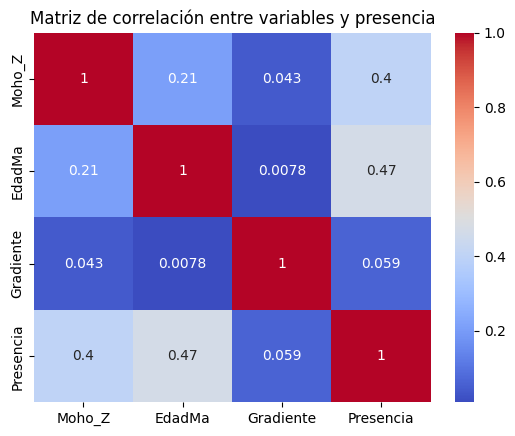

In [2]:
# -*- coding: utf-8 -*-
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from scipy.interpolate import griddata
from libpysal.weights import Queen
from spreg import GM_Lag, GM_Error_Het

# === Cargar shapefiles ===
gdf_depositos = gpd.read_file("C:/Git_SCA/AGE/Depositos").to_crs(epsg=4326)
gdf_moho = gpd.read_file("C:/Git_SCA/AGE/Corteza").to_crs(epsg=4326)
gdf_dataciones = gpd.read_file("C:/Git_SCA/AGE/Dataciones").to_crs(epsg=4326)
gdf_gradiente = gpd.read_file("C:/Git_SCA/AGE/Geotermica").to_crs(epsg=4326)
area_col = gpd.read_file("C:/Git_SCA/AGE/Area_Col").to_crs(epsg=4326)

# === Crear pseudo-ausencias ===
gdf_depositos["Presencia"] = 1
num_depos = len(gdf_depositos)
rng = np.random.default_rng(42)
pseudo_points = [Point(rng.uniform(-80, -65), rng.uniform(-5, 15)) for _ in range(num_depos)]
gdf_aus = gpd.GeoDataFrame(geometry=pseudo_points, crs="EPSG:4326")
gdf_aus["Presencia"] = 0

# === Unir datos y extraer coordenadas ===
gdf_total = pd.concat([gdf_depositos, gdf_aus], ignore_index=True)
gdf_total["X"] = gdf_total.geometry.x
gdf_total["Y"] = gdf_total.geometry.y

# === Interpolaciones ===
def interpolar(gdf, columna, grid_x, grid_y, filtro=None):
    gdf = gdf.copy()
    gdf[columna] = pd.to_numeric(gdf[columna].astype(str).str.replace(",", "."), errors="coerce")
    if filtro:
        gdf = gdf.query(filtro)
    coords = np.array([[p.x, p.y] for p in gdf.geometry])
    valores = gdf[columna].values
    grid = griddata(coords, valores, (grid_x, grid_y), method="cubic")
    grid[np.isnan(grid)] = griddata(coords, valores, (grid_x[np.isnan(grid)], grid_y[np.isnan(grid)]), method="nearest")
    return grid

grid_x, grid_y = np.mgrid[-80:-65:500j, -5:15:500j]
grid_moho = interpolar(gdf_moho, "Z", grid_x, grid_y)
grid_edad = interpolar(gdf_dataciones, "EdadMa", grid_x, grid_y, "EdadMa <= 4000")
grid_grad = interpolar(gdf_gradiente, "GRADIENTE", grid_x, grid_y)

def sample_grid_value(x, y, grid, xmin=-80, xmax=-65, ymin=-5, ymax=15, n=500):
    ix = int((x - xmin) / ((xmax - xmin) / n))
    iy = int((ymax - y) / ((ymax - ymin) / n))
    if 0 <= ix < n and 0 <= iy < n:
        return grid[iy, ix]
    return np.nan

gdf_total["Moho_Z"] = gdf_total.apply(lambda r: sample_grid_value(r.X, r.Y, grid_moho), axis=1)
gdf_total["EdadMa"] = gdf_total.apply(lambda r: sample_grid_value(r.X, r.Y, grid_edad), axis=1)
gdf_total["Gradiente"] = gdf_total.apply(lambda r: sample_grid_value(r.X, r.Y, grid_grad), axis=1)

# === Dataset final ===
gdf_modelo = gdf_total.dropna(subset=["Moho_Z", "EdadMa", "Gradiente"])
gdf_modelo = gdf_modelo[gdf_modelo["EdadMa"] <= 4000].copy()

# === Proyecciones ===
gdf_modelo = gdf_modelo.to_crs(epsg=3857)
area_col = area_col.to_crs(epsg=3857)

# === Matriz de pesos espaciales ===
w = Queen.from_dataframe(gdf_modelo)
w.transform = 'r'

# === Variables ===
X = gdf_modelo[["Moho_Z", "EdadMa", "Gradiente"]].values
y = gdf_modelo["Presencia"].values.reshape(-1, 1)

# === Modelo SLX ===
modelo_slx = GM_Lag(y, X, w=w, name_y="Presencia", name_x=["Moho_Z", "EdadMa", "Gradiente"], name_w="Queen", lag_q=True)
print("\nResumen del Modelo SLX:\n")
print(modelo_slx.summary)

# === Modelo ESF (Spatial Error with Heteroskedasticity) ===
modelo_esf = GM_Error_Het(y, X, w=w, name_y="Presencia", name_x=["Moho_Z", "EdadMa", "Gradiente"], name_w="Queen")
print("\nResumen del Modelo ESF:\n")
print(modelo_esf.summary)

# === Matriz de correlación ===
gdf_modelo["Presencia"] = y
df_vars = gdf_modelo[["Moho_Z", "EdadMa", "Gradiente", "Presencia"]]
sns.heatmap(df_vars.corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de correlación entre variables y presencia")
plt.show()


C:\TEMP\ipykernel_8152\245053950.py:7: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_modelo)



Resumen del Modelo ESF:

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: GM SPATIALLY WEIGHTED LEAST SQUARES (HET)
------------------------------------------------------------
Data set            :     unknown
Weights matrix      :       Queen
Dependent Variable  :   Presencia                Number of Observations:        1740
Mean dependent var  :      0.5092                Number of Variables   :           4
S.D. dependent var  :      0.5001                Degrees of Freedom    :        1736
Pseudo R-squared    :      0.2021
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -0.11599         0.11959        -0.96992         0.33209
              Moho_Z         0

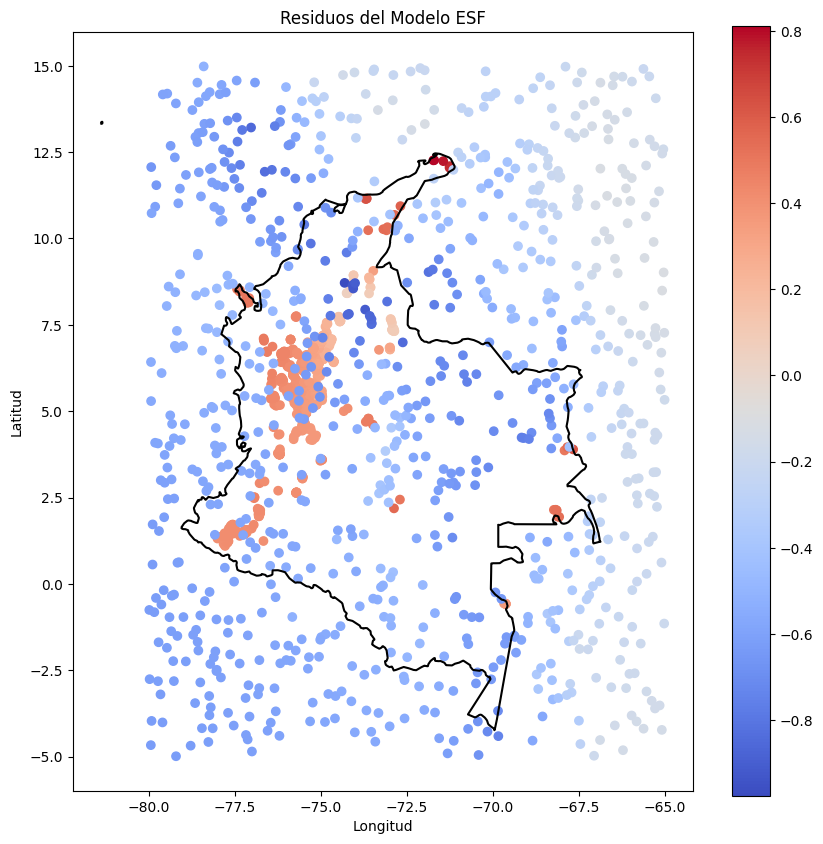

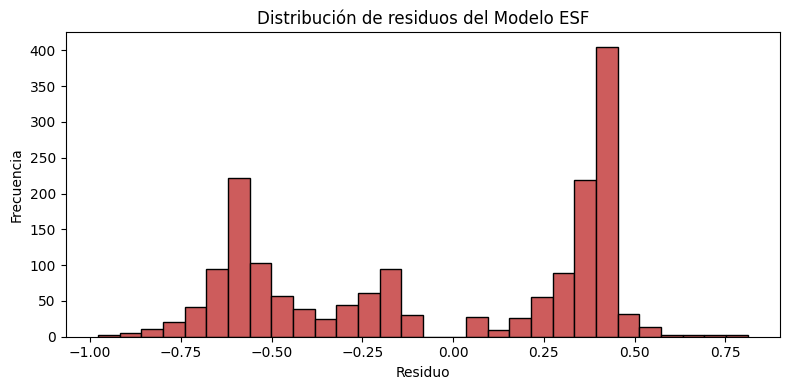

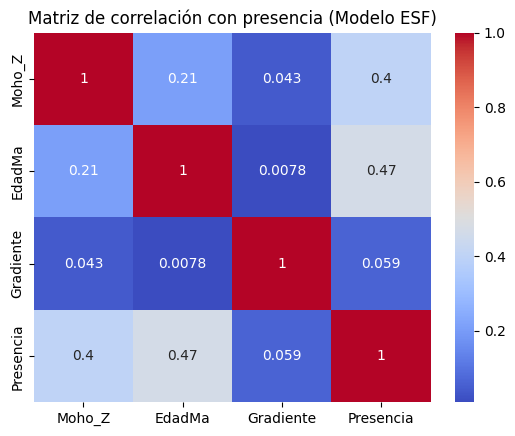

In [3]:
from libpysal.weights import Queen
from spreg import GM_Error_Het
import matplotlib.pyplot as plt
import seaborn as sns

# === Matriz de pesos espaciales ===
w = Queen.from_dataframe(gdf_modelo)
w.transform = 'r'

# === Variables ===
X = gdf_modelo[["Moho_Z", "EdadMa", "Gradiente"]].values
y = gdf_modelo["Presencia"].values.reshape(-1, 1)

# === Ajustar modelo ESF ===
modelo_esf = GM_Error_Het(y, X, w=w, name_y="Presencia", name_x=["Moho_Z", "EdadMa", "Gradiente"], name_w="Queen")

# === Mostrar resumen ===
print("\nResumen del Modelo ESF:\n")
print(modelo_esf.summary)

# === Residuales ===
gdf_modelo["residuos_esf"] = modelo_esf.u

# === Visualizar residuos sobre mapa ===
gdf_modelo = gdf_modelo.to_crs(epsg=4326)
area_col = area_col.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))
area_col.boundary.plot(ax=ax, color="black")
gdf_modelo.plot(column="residuos_esf", cmap="coolwarm", ax=ax, legend=True)
plt.title("Residuos del Modelo ESF")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

# === Histograma de residuos ===
plt.figure(figsize=(8, 4))
plt.hist(modelo_esf.u, bins=30, color="indianred", edgecolor="black")
plt.title("Distribución de residuos del Modelo ESF")
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# === Correlación con presencia ===
df_vars = gdf_modelo[["Moho_Z", "EdadMa", "Gradiente", "Presencia"]]
sns.heatmap(df_vars.corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de correlación con presencia (Modelo ESF)")
plt.show()
